# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

# Get data : obs, PPE, p1

In [6]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [7]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'
df_obs

time  temperature       clim          ta
lat        lon                                                  
-88.927735 0.00000    1979.0     0.768801 -25.193111  248.725677
           1.40625    1979.0     0.769734 -25.215549  248.704178
           2.81250    1979.0     0.770550 -25.236740  248.683807
           4.21875    1979.0     0.771259 -25.256731  248.664520
           5.62500    1979.0     0.771860 -25.276089  248.645767
...                      ...          ...        ...         ...
 88.927735 352.96875  1981.0     0.004460 -30.711264  242.443192
           354.37500  1981.0    -0.004911 -30.734428  242.410660
           355.78125  1981.0    -0.016334 -30.728228  242.405426
           357.18750  1981.0    -0.024906 -30.703251  242.421844
           358.59375  1981.0    -0.041427 -30.653141  242.455429

[1179648 rows x 4 columns]

In [8]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 -46.88067 -46.921864 ... -19.784966
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

In [9]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [10]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

In [11]:
amip['p1'] = p1_amip

In [12]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [13]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [14]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [15]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [16]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

# Bootstrap

In [17]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred, variable) :
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")    

    y_train = pc_train[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [18]:
def emulator_eval_EOF_modes(X_train, X_test, y_train, y_test) : 

    # Create an EOF solver to do the EOF analysis. 
    solver = Eof(y_train, center=False, weights=None)
    pc_train = solver.pcs(npcs=102, pcscaling=1)

    # Prediction and skill evaluation : loop over the 91 modes
    pc_test = solver.projectField(y_test, neofs=102, weighted=False, eofscaling=1)
    x_pred_IS = X_train
    x_pred_OS = X_test
    r_corr_list_IS = []
    r_corr_list_OS = []
    for EOF_nb in range(1,len(pc_train), 1) :
        y_pred_OS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_OS, variable)
        pc_test_tmp = pc_test[:,EOF_nb-1]
        df_OS = pd.DataFrame(y_pred_OS, columns=['pred'])
        df_OS['true'] = pc_test_tmp
        r_corr_OS = np.corrcoef(df_OS['pred'], df_OS['true'])
        r_corr_list_OS.append(r_corr_OS[0,1])
    
        y_pred_IS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_IS, variable)
        df_IS = pd.DataFrame(y_pred_IS, columns=['pred'])
        pc_train_tmp = pc_train[:,EOF_nb-1]
        df_IS['true'] = pc_train_tmp
        r_corr_IS = np.corrcoef(df_IS['pred'], df_IS['true'])
        r_corr_list_IS.append(r_corr_IS[0,1])
    
    return r_corr_list_OS, r_corr_list_IS

In [19]:
from sklearn.model_selection import train_test_split
EOF_nb = 1
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = anom_w[1:]

df_fig = pd.DataFrame(range(1, 91, 1), columns=['mode'])
for cpt in range(1,11,1) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    r_corr_list_OS, r_corr_list_IS = emulator_eval_EOF_modes(X_train, X_test, y_train, y_test)
    df_fig['r_OS_'+str(cpt)] = r_corr_list_OS
    df_fig['r_IS_'+str(cpt)] = r_corr_list_IS

df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_6,r_IS_6,r_OS_7,r_IS_7,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10
0,1,0.880918,0.948992,0.965306,0.941297,0.863820,0.956909,0.852235,0.952888,0.728964,...,0.881850,0.948904,0.849372,0.956977,0.900924,0.953953,0.938905,0.948691,0.916436,0.950323
1,2,0.839045,0.951577,0.874546,0.951250,0.921351,0.941835,0.823735,0.949795,0.926020,...,0.916431,0.948310,0.887902,0.948175,0.891530,0.953166,0.681781,0.955501,0.772597,0.955679
2,3,0.706764,0.915705,0.845131,0.894099,0.641561,0.927630,0.809968,0.898580,0.699578,...,0.739793,0.903295,0.609464,0.902002,0.959423,0.882061,0.508164,0.911212,0.560942,0.911460
3,4,0.491430,0.889052,0.671211,0.874701,0.852674,0.812151,0.770100,0.798197,0.699777,...,0.716521,0.909476,0.528238,0.803309,0.700514,0.835221,0.598390,0.854769,0.670565,0.858487
4,5,0.827004,0.856932,0.894462,0.869914,0.906967,0.919027,0.829426,0.899387,0.811423,...,0.678202,0.809489,0.916778,0.926314,0.808491,0.911530,0.562488,0.915094,0.722208,0.867138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,-0.253732,0.452946,0.344759,0.404565,-0.269692,0.508748,0.251973,0.371438,-0.121753,...,-0.080536,0.460955,0.202181,0.400729,0.231021,0.367244,0.676978,0.338809,-0.385237,0.434012
86,87,-0.012921,0.548442,-0.124719,0.423571,0.022236,0.546924,-0.322910,0.568967,-0.106942,...,-0.038047,0.379973,0.341815,0.358387,0.061908,0.443213,0.110906,0.448671,0.458249,0.436762
87,88,0.620908,0.466454,0.413540,0.626099,-0.236923,0.488182,0.357600,0.433924,0.566759,...,-0.283727,0.520289,0.023337,0.411452,-0.039394,0.343948,0.337736,0.529812,-0.349301,0.588000
88,89,0.367292,0.544084,0.039892,0.470283,-0.017909,0.356141,-0.171130,0.474550,-0.256571,...,-0.158657,0.409714,0.133714,0.457912,-0.087606,0.356111,-0.710618,0.473307,-0.024850,0.421661


In [20]:
df_OS = pd.DataFrame(df_fig['r_OS_1'], columns=['r1'])
df_IS = pd.DataFrame(df_fig['r_IS_1'], columns=['r1'])

for j in range(2,11,1) :
    df_OS['r'+str(j)] = df_fig['r_OS_'+str(j)]
    df_IS['r'+str(j)] = df_fig['r_IS_'+str(j)]

r_OS_mean = df_OS.mean(axis = 1)
r_OS_std = df_OS.std(axis = 1)
df_fig['r_OS_mean'] = r_OS_mean
df_fig['r_OS_std'] = r_OS_std

r_IS_mean = df_IS.mean(axis = 1)
r_IS_std = df_IS.std(axis = 1)
df_fig['r_IS_mean'] = r_IS_mean
df_fig['r_IS_std'] = r_IS_std

df_fig['mode'] = range(0, 90, 1)
df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10,r_OS_mean,r_OS_std,r_IS_mean,r_IS_std
0,0,0.880918,0.948992,0.965306,0.941297,0.863820,0.956909,0.852235,0.952888,0.728964,...,0.900924,0.953953,0.938905,0.948691,0.916436,0.950323,0.877535,0.068231,0.951663,0.004994
1,1,0.839045,0.951577,0.874546,0.951250,0.921351,0.941835,0.823735,0.949795,0.926020,...,0.891530,0.953166,0.681781,0.955501,0.772597,0.955679,0.855099,0.082000,0.949759,0.004758
2,2,0.706764,0.915705,0.845131,0.894099,0.641561,0.927630,0.809968,0.898580,0.699578,...,0.959423,0.882061,0.508164,0.911212,0.560942,0.911460,0.708225,0.145422,0.904332,0.012747
3,3,0.491430,0.889052,0.671211,0.874701,0.852674,0.812151,0.770100,0.798197,0.699777,...,0.700514,0.835221,0.598390,0.854769,0.670565,0.858487,0.689777,0.092923,0.839157,0.038121
4,4,0.827004,0.856932,0.894462,0.869914,0.906967,0.919027,0.829426,0.899387,0.811423,...,0.808491,0.911530,0.562488,0.915094,0.722208,0.867138,0.792272,0.118232,0.893114,0.038032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,-0.253732,0.452946,0.344759,0.404565,-0.269692,0.508748,0.251973,0.371438,-0.121753,...,0.231021,0.367244,0.676978,0.338809,-0.385237,0.434012,0.094410,0.334874,0.408455,0.052223
86,86,-0.012921,0.548442,-0.124719,0.423571,0.022236,0.546924,-0.322910,0.568967,-0.106942,...,0.061908,0.443213,0.110906,0.448671,0.458249,0.436762,0.044722,0.239313,0.444830,0.071005
87,87,0.620908,0.466454,0.413540,0.626099,-0.236923,0.488182,0.357600,0.433924,0.566759,...,-0.039394,0.343948,0.337736,0.529812,-0.349301,0.588000,0.087736,0.340154,0.485885,0.089845
88,88,0.367292,0.544084,0.039892,0.470283,-0.017909,0.356141,-0.171130,0.474550,-0.256571,...,-0.087606,0.356111,-0.710618,0.473307,-0.024850,0.421661,-0.139304,0.244616,0.429692,0.047388


In [21]:
cumul_corr_mean = []
cumul_corr_std = []
for i in range(0, len(df_fig), 1) :
    tmp = df_fig[0:i]['r_OS_mean'].mean()
    cumul_corr_mean.append(tmp)
    
    tmp = df_fig[0:i]['r_OS_std'].mean()
    cumul_corr_std.append(tmp)
    
df_fig['cumul_corr_mean'] = cumul_corr_mean
df_fig['cumul_corr_std'] = cumul_corr_std

In [22]:
## Test moyenne de corrélation pour 5, 10, 15, 20, 25, 50, 75 
mean_OS_5 = df_fig[0:5]['r_OS_mean'].mean()
mean_OS_10 = df_fig[0:10]['r_OS_mean'].mean()
mean_OS_15 = df_fig[0:15]['r_OS_mean'].mean()
mean_OS_20 = df_fig[0:20]['r_OS_mean'].mean()
mean_OS_25 = df_fig[0:25]['r_OS_mean'].mean()
mean_OS_50 = df_fig[0:50]['r_OS_mean'].mean()

# Figure

In [25]:
trunc=17

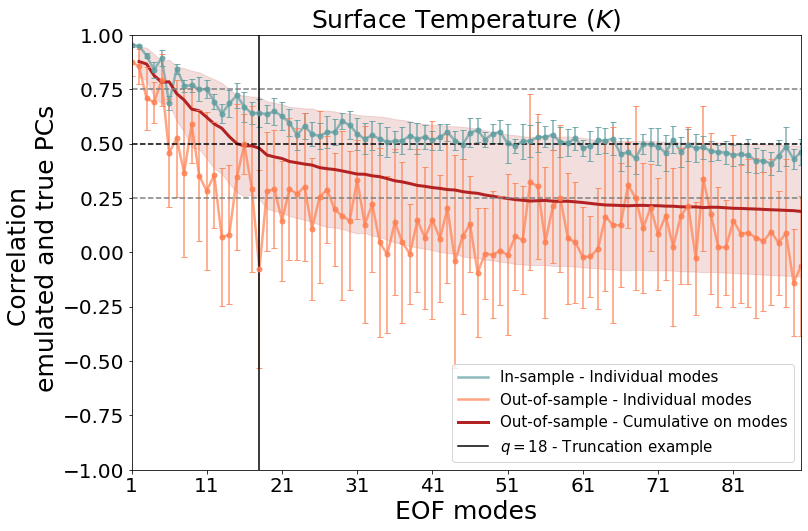

In [26]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()

df_fig.plot(kind='line', y='r_IS_mean', color = 'cadetblue', alpha=0.7, linewidth=2.5, ax=ax)
df_fig.plot(kind='line', y='r_OS_mean', color = 'coral', alpha=0.7, linewidth=2.5, ax=ax)

df_fig.plot(kind='line', y='cumul_corr_mean', color = 'firebrick', alpha=1, linewidth=3, ax=ax)
xfit = df_fig['mode']
yfit = df_fig['cumul_corr_mean']
dyfit = df_fig['cumul_corr_std']
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='firebrick', alpha=0.15)

plt.errorbar(x=df_fig['mode'], y=df_fig['r_IS_mean'], yerr=df_fig['r_IS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='cadetblue', 
             color= 'cadetblue')

plt.errorbar(x=df_fig['mode'], y=df_fig['r_OS_mean'], yerr=df_fig['r_OS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='coral', 
             color= 'coral')

plt.axhline(y=0.5, color='black', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.25, color='gray', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.75, color='gray', linestyle='dashed', label = '_nolegend_')

plt.axvline(x=trunc, color='black', linestyle='solid')

#ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('EOF modes', size = 25)
ax.set_ylabel('Correlation \n emulated and true PCs', size = 25)
ax.set_title('Surface Temperature ($K$)', fontsize=25)
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(1, 91, 10))

plt.xticks(rotation=0)

# Legend .................

legend = [ 'In-sample - Individual modes', 'Out-of-sample - Individual modes', 
          'Out-of-sample - Cumulative on modes', '$q=$'+str(trunc+1)+' - Truncation example']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Skill_emul_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()